In [1]:
# Add package root to the path
import sys
from pathlib import Path
path_root = Path().resolve().parents[0]
sys.path.append(str(path_root))
path_root

PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort')

In [2]:
import argparse
import json
import torch
from torch.utils.data import DataLoader

from utils.paths_collector import Paths
from data.carrada.dataset import Carrada
from evaluation.tester import Tester
from mvrss.utils.functions import count_params
# from mvrss.learners.tester import Tester
from mvrss.models import TMVANet, MVNet
# from mvrss.loaders.dataset import Carrada
from mvrss.loaders.dataloaders import SequenceCarradaDataset

In [3]:
# PARAMETERS
args = {
    'cfg': '/Users/daniel/Idan/University/Masters/Thesis/2024/datasets/logs/carrada/mvnet/mvnet_e300_lr0.0001_s42_0/config.json',
}

target_seq = '2019-09-16-12-55-51' # None for all
frame_num_plot = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
    cfg_path = args["cfg"]
    with open(cfg_path, 'r') as fp:
        cfg = json.load(fp)

In [5]:
    paths = Paths().get()

    exp_name = cfg['name_exp'] + '_' + str(cfg['version'])
    path = paths['logs'] / cfg['dataset'] / cfg['model'] / exp_name
    model_path = path / 'results' / 'model.pt'
    test_results_path = path / 'results' / 'test_results.json'

In [6]:
paths

{'warehouse': PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/datasets'),
 'logs': PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/datasets/logs'),
 'carrada': PosixPath('/Users/daniel/Idan/University/Masters/Thesis/2024/datasets/Carrada'),
 'config': '/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort/configs/config.ini'}

In [7]:
    if cfg['model'] == 'mvnet':
        model = MVNet(n_classes=cfg['nb_classes'], n_frames=cfg['nb_input_channels'])
    else:
        model = TMVANet(n_classes=cfg['nb_classes'], n_frames=cfg['nb_input_channels'])
    print('Number of trainable parameters in the model: %s' % str(count_params(model)))
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model = model.to(device)

Number of trainable parameters in the model: 2375432


/var/folders/wh/181dmx3d2v94m8cyv4ny1s_w0000gn/T/ipykernel_85428/2230332469.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

In [8]:
tester = Tester(cfg)

data = Carrada(config_model=cfg)
test = data.get('Train')

In [9]:
# Select the target sequence if specified
if target_seq is not None:
    test = {target_seq: test[target_seq]}
    
testset = SequenceCarradaDataset(test)
seq_testloader = DataLoader(
    testset,
    batch_size=1,
    shuffle=False, 
    num_workers=0
)

In [10]:
tester.set_annot_type(cfg['annot_type'])

In [11]:
"""
Method to predict on a given dataset using a fixed model

PARAMETERS
----------
net: PyTorch Model
    Network to test
seq_loader: DataLoader
    Specific to the dataset used for test
iteration: int
    Iteration used to display visualization
    Default: None
get_quali: boolean
    If you want to save qualitative results
    Default: False
add_temp: boolean
    Is the data are considered as a sequence
    Default: False
"""
        
# if cfg['model'] == 'mvnet':
#     test_results = tester.predict(model, seq_testloader, get_quali=True, add_temp=False)
# else:
#     test_results = tester.predict(model, seq_testloader, get_quali=True, add_temp=True)

'\nMethod to predict on a given dataset using a fixed model\n\nPARAMETERS\n----------\nnet: PyTorch Model\n    Network to test\nseq_loader: DataLoader\n    Specific to the dataset used for test\niteration: int\n    Iteration used to display visualization\n    Default: None\nget_quali: boolean\n    If you want to save qualitative results\n    Default: False\nadd_temp: boolean\n    Is the data are considered as a sequence\n    Default: False\n'

In [12]:
# tester.write_params(test_results_path)
# test_results_path

# Predict Method Walkthrough
This notebook breaks down the `predict` method of the Tester class step by step

## 1. Imports and Initial Setup
First we need all required imports and configuration

In [13]:
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from mvrss.utils.functions import transform_masks_viz, get_metrics, normalize, define_loss, get_transformations, get_qualitatives
# from mvrss.utils.paths import Paths
from mvrss.utils.metrics import Evaluator
from mvrss.loaders.dataloaders import CarradaDataset

from utils.paths_collector import Paths

In [14]:
net, seq_loader = model, seq_testloader
iteration=None
get_quali=True
add_temp=True

visualizer = None

In [15]:
        cfg = cfg
        visualizer = visualizer
        model = cfg['model']
        nb_classes = cfg['nb_classes']
        annot_type = cfg['annot_type']
        process_signal = cfg['process_signal']
        w_size = cfg['w_size']
        h_size = cfg['h_size']
        n_frames = cfg['nb_input_channels']
        batch_size = cfg['batch_size']
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        custom_loss = cfg['custom_loss']
        transform_names = cfg['transformations'].split(',')
        norm_type = cfg['norm_type']
        paths = Paths().get()
        test_results = dict()

## Setup - Preparing the Evaluation Environment
In this cell, we set the network to evaluation mode, create the test-time transformations, initialize loss functions and evaluation metrics, and define some lists to collect running losses. We also set a random sequence index if you are using visualization for a specific iteration.

In [16]:
cfg  # Set the network to evaluation mode
net.eval()

# Prepare transformations for the test split (assumes get_transformations is defined)
transformations = get_transformations(
    transform_names, split='test', sizes=(w_size, h_size))

# Define loss functions for range_doppler and range_angle (assumes define_loss is defined)
rd_criterion = define_loss('range_doppler', custom_loss, device)
ra_criterion = define_loss('range_angle', custom_loss, device)
nb_losses = len(rd_criterion)

# Initialize lists to store running losses and detailed sub-losses
running_losses = []
rd_running_losses = []
rd_running_global_losses = [[], []]  # Two sub-losses for range_doppler
ra_running_losses = []
ra_running_global_losses = [[], []]  # Two sub-losses for range_angle
coherence_running_losses = []

# Initialize evaluators for metrics (assumes Evaluator is defined)
rd_metrics = Evaluator(num_class=nb_classes)
ra_metrics = Evaluator(num_class=nb_classes)

# If an iteration number is provided, choose a random sequence from the loader for visualization
if iteration is not None:
    rand_seq = np.random.randint(len(seq_loader))

## Looping Over Sequences
Here we iterate over the sequences in the seq_loader. For each sequence, we create a frame-level dataloader and prepare for potential visualization if the iteration flag is set.

In [17]:
# Loop over each sequence in the seq_loader
for i, sequence_data in enumerate(seq_loader):
    seq_name, seq = sequence_data
    # Construct the path to the frames (assumes paths is defined with key 'carrada')
    path_to_frames = paths['carrada'] / seq_name[0]
    
    # Create a DataLoader for the current sequence frames (assumes CarradaDataset is defined)
    frame_dataloader = DataLoader(
        CarradaDataset(seq, annot_type, path_to_frames, process_signal, n_frames, transformations, add_temp),
        shuffle=False,
        batch_size=batch_size,
        num_workers=4
    )
    
    # If visualization is enabled and we are on the random sequence, choose a random frame index
    if iteration is not None and i == rand_seq:
        rand_frame = np.random.randint(len(frame_dataloader))
    
    # Set qualitative iteration counters (for visualization) if qualitative results are needed
    if get_quali:
        quali_iter_rd = n_frames - 1
        quali_iter_ra = n_frames - 1


## Processing Each Frame
Within each sequence, we loop over the frames. For each frame we:

-    Load and normalize the data (range-doppler, range-angle, and optionally angle-doppler).

-    Pass the data through the network.
-    Compute the predictions and optionally save qualitative results.
-   Update the evaluation metrics.
-   Compute and store the losses

In [18]:
# Get frame_num_plot from the dataloader
for frame_num, frame in enumerate(frame_dataloader):
    rd_mask = frame['rd_mask'].to(device).float()
    if rd_mask[0][1:].max() > 0.0:
        frame_num_plot -= 1
        print(
            f"frame number: {frame_num}, max value = {rd_mask[0][1:].max()} yeyy")
        if frame_num_plot == 0:
            break
        
# Retrieve tensors and move them to the device (assumes proper keys exist in frame)
rd_data = frame['rd_matrix'].to(device).float()
ra_data = frame['ra_matrix'].to(device).float()
ad_data = frame['ad_matrix'].to(device).float()  # Only used if model is 'tmvanet'
rd_mask = frame['rd_mask'].to(device).float()
ra_mask = frame['ra_mask'].to(device).float()

# Normalize the inputs (assumes normalize is defined)
rd_data = normalize(rd_data, 'range_doppler', norm_type=norm_type).squeeze()
ra_data = normalize(ra_data, 'range_angle', norm_type=norm_type).squeeze()

frame number: 3, max value = 1.0 yeyy
frame number: 4, max value = 1.0 yeyy
frame number: 5, max value = 1.0 yeyy
frame number: 6, max value = 1.0 yeyy
frame number: 15, max value = 1.0 yeyy


In [19]:
rd_mask[0][1:].max()

tensor(1.)

In [20]:
# Forward pass through the network (check if model requires angle_doppler data)
if model == 'tmvanet':
    ad_data = normalize(ad_data, 'angle_doppler', norm_type=norm_type).squeeze()
    rd_outputs, ra_outputs = net(rd_data, ra_data, ad_data)
else:
    rd_outputs, ra_outputs = net(rd_data, ra_data)

# Ensure outputs are on the proper device
rd_outputs = rd_outputs.to(device)
ra_outputs = ra_outputs.to(device)
ra_outputs.shape

torch.Size([15, 4, 256, 256])

# Plotting the Results
Finally, we plot the results using the `plot_results` method. This method takes the collected losses and metrics and generates visualizations to help us understand the model's performance.

In [23]:
import matplotlib.pyplot as plt

In [24]:
rd_pred_masks = torch.argmax(rd_outputs, axis=1)[:5]
ra_pred_masks = torch.argmax(ra_outputs, axis=1)[:5]
rd_gt_masks = torch.argmax(rd_mask, axis=1)[:5]
ra_gt_masks = torch.argmax(ra_mask, axis=1)[:5]
rd_pred_grid = make_grid(transform_masks_viz(rd_pred_masks,
                                                nb_classes))
ra_pred_grid = make_grid(transform_masks_viz(ra_pred_masks,
                                                nb_classes))
rd_gt_grid = make_grid(transform_masks_viz(rd_gt_masks,
                                            nb_classes))
ra_gt_grid = make_grid(transform_masks_viz(ra_gt_masks,
                                            nb_classes))
# visualizer.update_multi_img_masks(rd_pred_grid, rd_gt_grid,
#                                         ra_pred_grid, ra_gt_grid,
#                                         iteration)


print("shapes:")
print(f"rd_pred_masks: {rd_pred_masks.shape}")
print(f"ra_pred_masks: {ra_pred_masks.shape}")
print(f"rd_gt_masks: {rd_gt_masks.shape}")
print(f"ra_gt_masks: {ra_gt_masks.shape}")
print(f"rd_pred_grid: {rd_pred_grid.shape}")
print(f"ra_pred_grid: {ra_pred_grid.shape}")


shapes:
rd_pred_masks: torch.Size([5, 256, 64])
ra_pred_masks: torch.Size([5, 256, 256])
rd_gt_masks: torch.Size([5, 256, 64])
ra_gt_masks: torch.Size([5, 256, 256])
rd_pred_grid: torch.Size([3, 260, 332])
ra_pred_grid: torch.Size([3, 260, 1292])


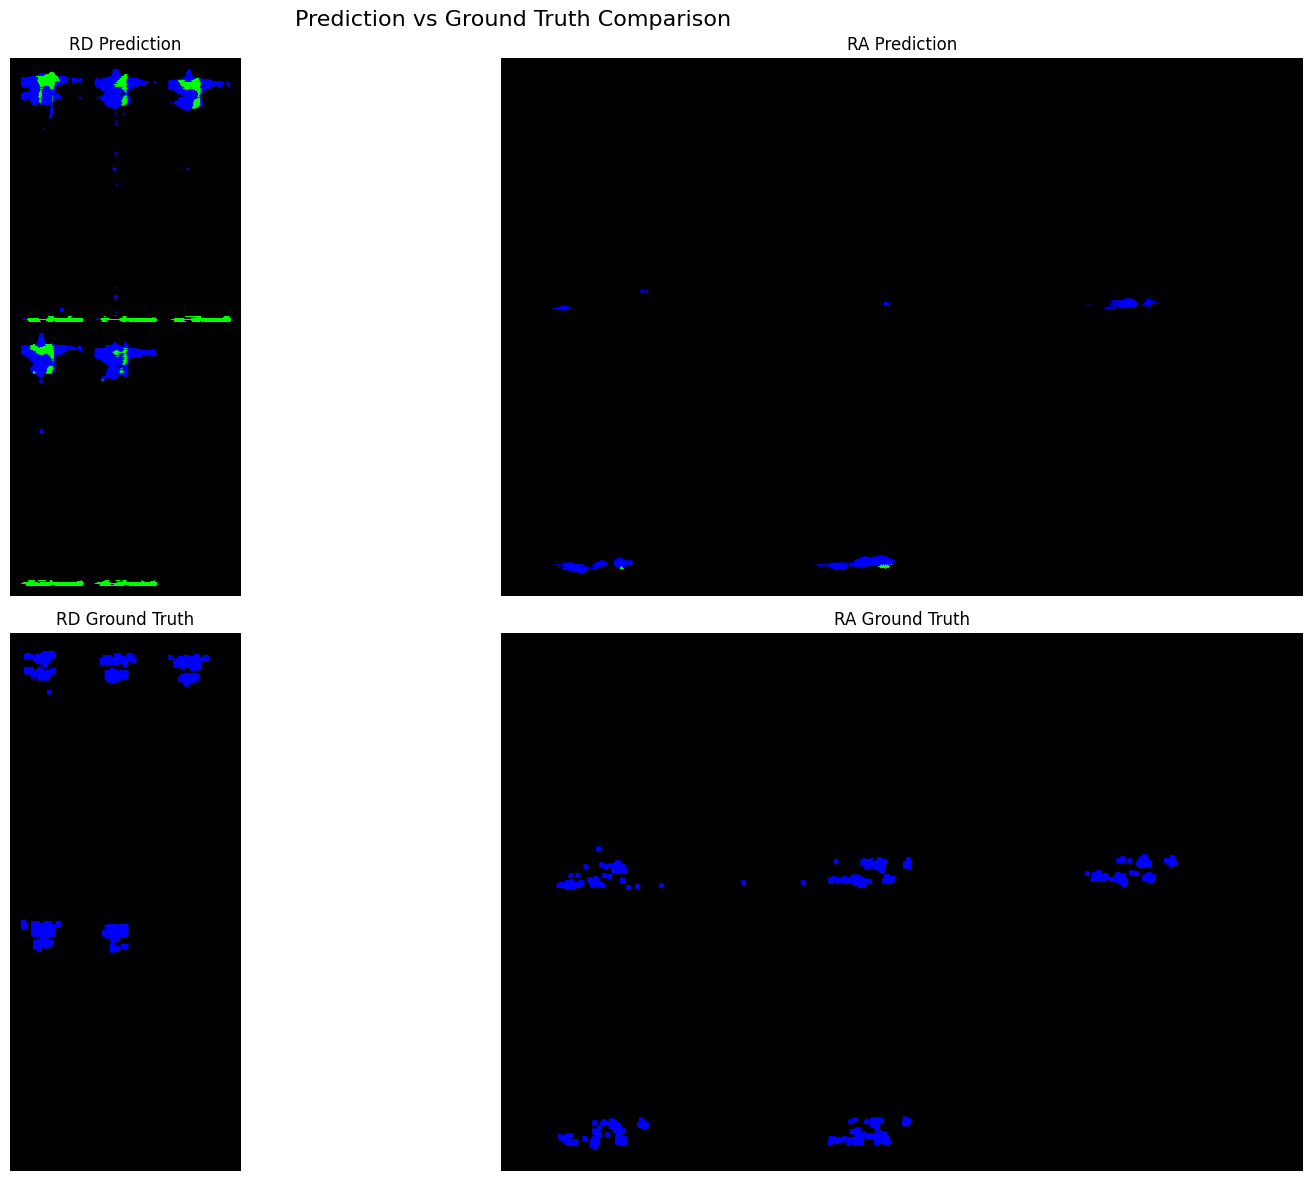

In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.utils import make_grid
from mvrss.utils.functions import mask_to_img


def prepare_grid(masks, nrow=3):
    """Convert batch of masks to RGB grid"""
    # Convert each mask to RGB image
    rgb_images = [mask_to_img(m.cpu().numpy()) for m in masks]
    # Convert PIL Images to tensors
    tensors = [torch.from_numpy(np.array(img)).permute(2, 0, 1)
               for img in rgb_images]
    # Create grid
    return make_grid(tensors, nrow=nrow, padding=10)


# Create grids from original masks (before argmax)
rd_pred_grid = prepare_grid(rd_pred_masks)
ra_pred_grid = prepare_grid(ra_pred_masks)
rd_gt_grid = prepare_grid(rd_gt_masks)
ra_gt_grid = prepare_grid(ra_gt_masks)

# Create comparison plot
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Prediction vs Ground Truth Comparison', fontsize=16)

images = [
    (rd_pred_grid, 'RD Prediction'),
    (ra_pred_grid, 'RA Prediction'),
    (rd_gt_grid, 'RD Ground Truth'),
    (ra_gt_grid, 'RA Ground Truth')
]

for ax, (img, title) in zip(axs.ravel(), images):
    # Process grid
    img = img.cpu().permute(1, 2, 0).numpy()
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()

IndexError: boolean index did not match indexed array along axis 2; size of axis is 3 but size of corresponding boolean axis is 232

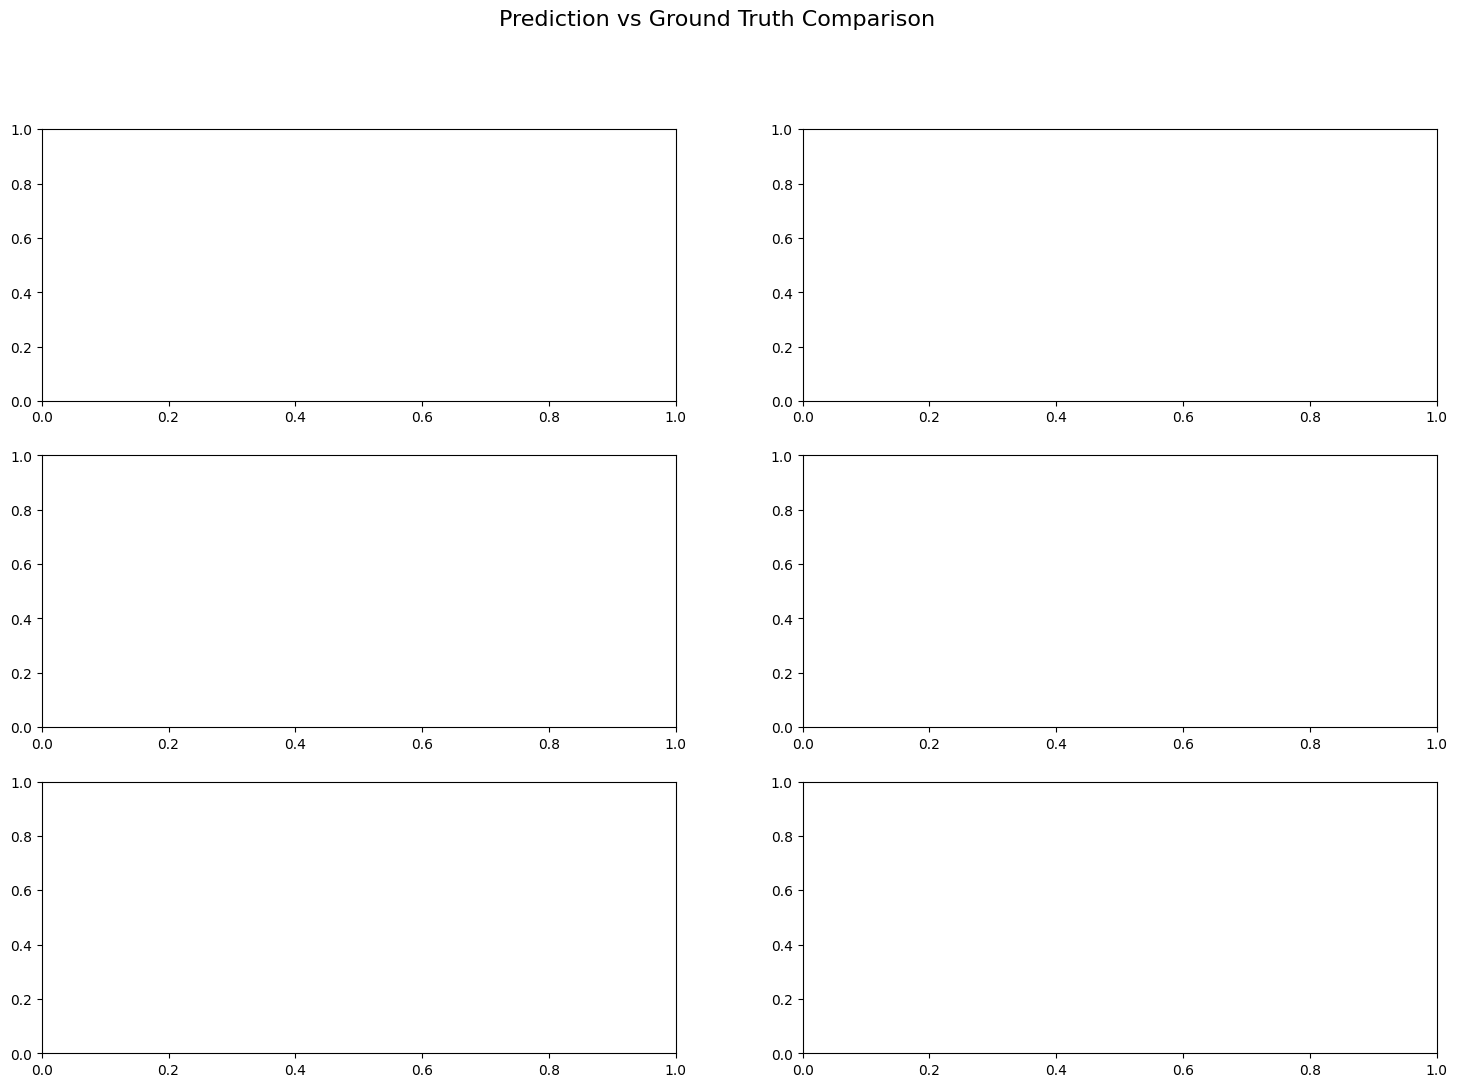

In [26]:
import matplotlib.pyplot as plt
import torch
from mvrss.utils.functions import mask_to_img

# Create a 2x2 grid for comparison
fig, axs = plt.subplots(3, 2, figsize=(18, 12))
fig.suptitle('Prediction vs Ground Truth Comparison', fontsize=16)

# List of images and their titles
images = [
    (rd_pred_grid, 'RD Prediction'),
    (ra_pred_grid, 'RA Prediction'),
    (rd_gt_grid, 'RD Ground Truth'),
    (ra_gt_grid, 'RA Ground Truth'),
    (mask_to_img(rd_pred_grid), 'RD Output'),
    (mask_to_img(rd_gt_grid), 'RD MASK'),

    
]

# Process and plot each image
for ax, (img, title) in zip(axs.ravel(), images):
    # Move to CPU and permute dimensions
    img = img.cpu().permute(1, 2, 0)

    # Normalize if needed
    if torch.max(img) > 1.0:
        img = img / img.max()

    # Plot with settings
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

    # Print diagnostics
    print(f'{title} - Min: {img.min():.2f}, Max: {img.max():.2f}, Mean: {img.mean():.2f}')

plt.tight_layout()
plt.show()

In [ ]:
    paths = Paths().get()

    exp_name = cfg['name_exp'] + '_' + str(cfg['version'])
    path = paths['logs'] / cfg['dataset'] / cfg['model'] / exp_name
    model_path = path / 'results' / 'model.pt'
    test_results_path = path / 'results' / 'test_results.json'

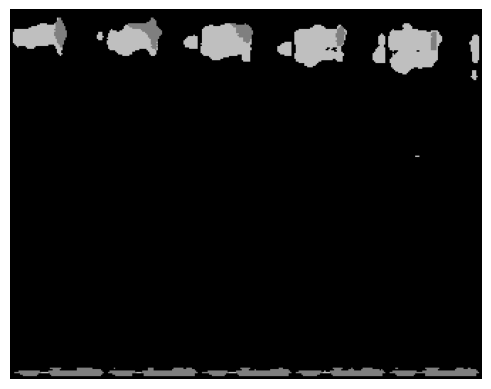

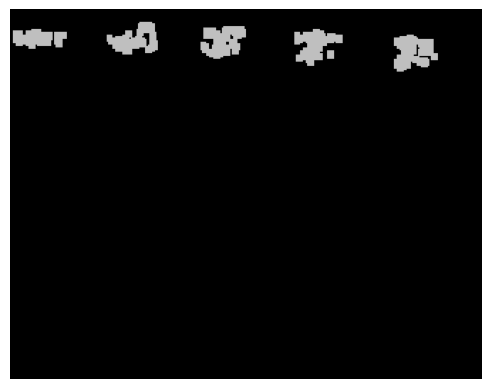

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(rd_pred_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
plt.imshow(rd_gt_grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()


In [ ]:
    # # Loop over frames in the current sequence
    # for j, frame in enumerate(frame_dataloader):
    #     # Retrieve tensors and move them to the device (assumes proper keys exist in frame)
    #     rd_data = frame['rd_matrix'].to(device).float()
    #     ra_data = frame['ra_matrix'].to(device).float()
    #     ad_data = frame['ad_matrix'].to(device).float()  # Only used if model is 'tmvanet'
    #     rd_mask = frame['rd_mask'].to(device).float()
    #     ra_mask = frame['ra_mask'].to(device).float()
        
    #     # Normalize the inputs (assumes normalize is defined)
    #     rd_data = normalize(rd_data, 'range_doppler', norm_type=norm_type).squeeze()
    #     ra_data = normalize(ra_data, 'range_angle', norm_type=norm_type).squeeze()
        
    #     # Forward pass through the network (check if model requires angle_doppler data)
    #     if model == 'tmvanet':
    #         ad_data = normalize(ad_data, 'angle_doppler', norm_type=norm_type).squeeze()
    #         rd_outputs, ra_outputs = net(rd_data, ra_data, ad_data)
    #     else:
    #         rd_outputs, ra_outputs = net(rd_data, ra_data)
        
    #     # Ensure outputs are on the proper device
    #     rd_outputs = rd_outputs.to(device)
    #     ra_outputs = ra_outputs.to(device)
        
    #     # Optional: save qualitative results if flag is enabled (assumes get_qualitatives is defined)
    #     if get_quali:
    #         quali_iter_rd = get_qualitatives(rd_outputs, rd_mask, paths, seq_name, quali_iter_rd, 'range_doppler')
    #         quali_iter_ra = get_qualitatives(ra_outputs, ra_mask, paths, seq_name, quali_iter_ra, 'range_angle')
        
    #     # Update evaluation metrics (assumes torch.argmax and Evaluator.add_batch are defined)
    #     rd_metrics.add_batch(torch.argmax(rd_mask, axis=1).cpu(),
    #                          torch.argmax(rd_outputs, axis=1).cpu())
    #     ra_metrics.add_batch(torch.argmax(ra_mask, axis=1).cpu(),
    #                          torch.argmax(ra_outputs, axis=1).cpu())
        
    #     # Compute losses depending on the number of loss functions
    #     if nb_losses < 3:
    #         # Case without the Coherence Loss (CoL)
    #         rd_losses = [c(rd_outputs, torch.argmax(rd_mask, axis=1)) for c in rd_criterion]
    #         rd_loss = torch.mean(torch.stack(rd_losses))
    #         ra_losses = [c(ra_outputs, torch.argmax(ra_mask, axis=1)) for c in ra_criterion]
    #         ra_loss = torch.mean(torch.stack(ra_losses))
    #         loss = torch.mean(rd_loss + ra_loss)
    #     else:
    #         # Case with the Coherence Loss (CoL)
    #         rd_losses = [c(rd_outputs, torch.argmax(rd_mask, axis=1)) for c in rd_criterion[:2]]
    #         rd_loss = torch.mean(torch.stack(rd_losses))
    #         ra_losses = [c(ra_outputs, torch.argmax(ra_mask, axis=1)) for c in ra_criterion[:2]]
    #         ra_loss = torch.mean(torch.stack(ra_losses))
    #         # Compute the coherence loss between rd_outputs and ra_outputs
    #         coherence_loss = rd_criterion[2](rd_outputs, ra_outputs)
    #         loss = torch.mean(rd_loss + ra_loss + coherence_loss)
        
    #     # Store the computed losses (use .data.cpu().numpy() to convert tensors to numpy values)
    #     running_losses.append(loss.data.cpu().numpy()[()])
    #     rd_running_losses.append(rd_loss.data.cpu().numpy()[()])
    #     rd_running_global_losses[0].append(rd_losses[0].data.cpu().numpy()[()])
    #     rd_running_global_losses[1].append(rd_losses[1].data.cpu().numpy()[()])
    #     ra_running_losses.append(ra_loss.data.cpu().numpy()[()])
    #     ra_running_global_losses[0].append(ra_losses[0].data.cpu().numpy()[()])
    #     ra_running_global_losses[1].append(ra_losses[1].data.cpu().numpy()[()])
    #     if nb_losses > 2:
    #         coherence_running_losses.append(coherence_loss.data.cpu().numpy()[()])
        
    #     # If this is the selected random sequence and frame, update the visualizations
    #     if iteration is not None and i == rand_seq:
    #         if j == rand_frame:
    #             # Get the predicted masks for visualization (take only first 5 for brevity)
    #             rd_pred_masks = torch.argmax(rd_outputs, axis=1)[:5]
    #             ra_pred_masks = torch.argmax(ra_outputs, axis=1)[:5]
    #             rd_gt_masks = torch.argmax(rd_mask, axis=1)[:5]
    #             ra_gt_masks = torch.argmax(ra_mask, axis=1)[:5]
    #             # Convert masks to grids for visualization (assumes make_grid and transform_masks_viz are defined)
    #             rd_pred_grid = make_grid(transform_masks_viz(rd_pred_masks, nb_classes))
    #             ra_pred_grid = make_grid(transform_masks_viz(ra_pred_masks, nb_classes))
    #             rd_gt_grid = make_grid(transform_masks_viz(rd_gt_masks, nb_classes))
    #             ra_gt_grid = make_grid(transform_masks_viz(ra_gt_masks, nb_classes))
    #             # Update visualization (assumes visualizer.update_multi_img_masks is defined)
    #             visualizer.update_multi_img_masks(rd_pred_grid, rd_gt_grid,
    #                                               ra_pred_grid, ra_gt_grid,
    #                                               iteration)


## Aggregating and Reporting the Results
After processing all sequences and frames, we aggregate the computed metrics and losses into a results dictionary. Finally, we reset the metric evaluators.

In [ ]:
# After processing all sequences, compute the final test results
test_results = dict()

# Compute metrics for both range_doppler and range_angle (assumes get_metrics is defined)
test_results['range_doppler'] = get_metrics(
    rd_metrics,
    np.mean(rd_running_losses),
    [np.mean(sub_loss) for sub_loss in rd_running_global_losses]
)
test_results['range_angle'] = get_metrics(
    ra_metrics,
    np.mean(ra_running_losses),
    [np.mean(sub_loss) for sub_loss in ra_running_global_losses]
)

# If coherence loss was computed, include it in the results
if nb_losses > 2:
    test_results['coherence_loss'] = np.mean(coherence_running_losses).item()

# Compute global metrics by averaging the two views
test_results['global_acc'] = 0.5 * \
    (test_results['range_doppler']['acc'] + test_results['range_angle']['acc'])
test_results['global_prec'] = 0.5 * \
    (test_results['range_doppler']['prec'] +
     test_results['range_angle']['prec'])
test_results['global_dice'] = 0.5 * \
    (test_results['range_doppler']['dice'] +
     test_results['range_angle']['dice'])

# Reset the metrics for potential further evaluations
rd_metrics.reset()
ra_metrics.reset()

# Display the final test results
print("Test Results:")
print(test_results)

Test Results:
{'range_doppler': {'loss': nan, 'loss_ce': nan, 'loss_dice': nan, 'acc': np.float64(0.0), 'acc_by_class': [0.0, 0.0, 0.0, 0.0], 'prec': np.float64(0.0), 'prec_by_class': [0.0, 0.0, 0.0, 0.0], 'recall': np.float64(0.0), 'recall_by_class': [0.0, 0.0, 0.0, 0.0], 'miou': np.float64(0.0), 'miou_by_class': [0.0, 0.0, 0.0, 0.0], 'dice': np.float64(0.0), 'dice_by_class': [0.0, 0.0, 0.0, 0.0]}, 'range_angle': {'loss': nan, 'loss_ce': nan, 'loss_dice': nan, 'acc': np.float64(0.0), 'acc_by_class': [0.0, 0.0, 0.0, 0.0], 'prec': np.float64(0.0), 'prec_by_class': [0.0, 0.0, 0.0, 0.0], 'recall': np.float64(0.0), 'recall_by_class': [0.0, 0.0, 0.0, 0.0], 'miou': np.float64(0.0), 'miou_by_class': [0.0, 0.0, 0.0, 0.0], 'dice': np.float64(0.0), 'dice_by_class': [0.0, 0.0, 0.0, 0.0]}, 'global_acc': np.float64(0.0), 'global_prec': np.float64(0.0), 'global_dice': np.float64(0.0)}


/Users/daniel/miniconda3/envs/radar_sort/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/daniel/miniconda3/envs/radar_sort/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort/external/MVRSS/mvrss/utils/metrics.py:41: RuntimeWarning: invalid value encountered in divide
  acc_by_class = np.diag(self.confusion_matrix).sum() / (np.nansum(self.confusion_matrix, axis=1)
/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort/external/MVRSS/mvrss/utils/metrics.py:21: RuntimeWarning: invalid value encountered in divide
  prec_by_class = np.diag(self.confusion_matrix) / np.nansum(self.confusion_matrix, axis=0)
/Users/daniel/Idan/University/Masters/Thesis/2024/radar_sort/external/MVRSS/mvrss/utils/metrics.py:31: RuntimeWarn